In [71]:
########################################
#LIBRARIES
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import os
import time

########################################
#PARAMETERS
print(time.strftime("%H%M"))
nTimeSteps = 60 #seconds
samplenum = 1000
epochs = 10
minibatch_size= 1
hiddenlayers = [100]
learning_rate = 0.001
LRdecay = 0.7
use_case = 'cube-drag'
model_file_path = '../Trained_Models/'
sample_file_path = f'../Data/Samples/data_cube-drag_{nTimeSteps}tsteps_2315/'
simulation_file_path = '../Data/Simulations/cube-drag.sim'
objective_file_path = f'../Data/Objectives/cube-drag.obj'


############################################
#LOAD SIMULATION PYDDE_V2
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init_0 = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init_0[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init_0)
r = dyn.r(state_init, p_init_0)
dr = dyn.dr_dp(state_init, p_init_0)
dq = dyn.dq_dp(state_init, p_init_0)

# check dde version
print("using dde version: " + dde.__version__)
# set log level
dde.set_log_level(dde.LogLevel.off)
print(f'log level set to {dde.get_log_level()}')

# set log level
dde.set_log_level(dde.LogLevel.off)

# Objective Function
obj = dde.InverseObjective(dyn)
obj.loadFile(objective_file_path)
objective_json = json.load(open(objective_file_path))
opt = dde.Newton()

##########################################
#SAMPLE TARGETS
input_size = 25 # target (0:3), q (3:9), qdot (9:15), qddot (15:21), p_now (21:25) 
output_size = dyn.nParameters*nTimeSteps
print(os.listdir(sample_file_path))

1030
using dde version: v0.1.2-20-g1cc6119-dirty
log level set to LogLevel.off
['data_1.json', 'data_16.json', 'data_17.json', 'data_0.json', 'data_10.json', 'data_7.json', 'cube.out', 'data_6.json', 'data_11.json', 'Description.json', 'data_9.json', 'data_12.json', 'data_5.json', 'data_4.json', 'data_8.json', 'data_13.json', 'data_3.json', 'data_18.json', 'data_14.json', 'Sampling_cube-drag.py', 'data_15.json', 'data_2.json', 'data_19.json']


In [87]:
#########################################
#LOAD TRAINING SAMPLES
number_of_files = len(os.listdir(sample_file_path))-3

with open(sample_file_path + f'data_0.json') as json_file:
    data = json.load(json_file)
    filesize = len(data['q_target'])
samplenum = filesize*number_of_files
input = np.zeros((samplenum, input_size))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        for i, q_target_i in enumerate(data['q_target']):
            input[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 3:9] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 9:15] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input[filenum*filesize+i, 15:21] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 21:25] = np.array(p_now_i)

print(f'Shape of input: {input.shape}')
#Remove zeros
input = input[~(input == 0).all(1)]
print(f'after removing zeros: {input.shape}')

# Splitting the dataset into the Training set and Test set
#from sklearn.model_selection import train_test_split
#y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

#y_target = torch.tensor(y_train).float()
#p = torch.tensor(p_train).float()
data = torch.tensor(input).float()
print(data.shape)
#y_test = torch.tensor(y_test).float()
#p_test = torch.tensor(p_test).float()
'''
def minmaxscale(input, extrema):
    if extrema == None:
        maximas= []
        minimas= []
        for i in range(len(input[0, :])):
            maximas.append(np.max(input[:,i]))
            minimas.append(np.min(input[:,i]))
        max = np.max(maximas)
        min = np.min(minimas)
        extrema = np.max([max, np.linalg.norm(min)])
        scaled = (input+extrema)/(2*extrema)
        return scaled, extrema
    else:
        scaled = (input+extrema)/(2*extrema)
        return scaled

data[:, 15:18], extr_qddot = minmaxscale(data[:, 15:18], None)
data[:, 18:21], extr_qddot = minmaxscale(data[:, 18:21], None)

def findnan(data):
    input=data.detach().clone().numpy()
    x=0
    for i in range(len(input[:,0])):
        for j in range(len(input[0,:])):
            if np.isnan(input[i,j]):
                x=x+1
                print(f'Index{j},{i} is a nan')
    print(f'{x} nans were found')
    return None

def findnan(data):
    input=data.detach().clone().numpy()
    x=0
    for i in range(len(input[:,0])):
        for j in range(len(input[0,:])):
            if np.isnan(input[i,j]):
                x=x+1
                print(f'Index{j},{i} is a nan')
    print(f'{x} nans were found')
    return None
findnan(data)
data = data[0:10, :]
samplenum = len(data[:,0])

def findnantorch(data):
    if torch.any(torch.isnan(data)):
        print(f'NAN found')
    return None
def findinftorch(data):
    if torch.any(torch.isinf(data)):
        infi = torch.isinf(data)
        print(f'INF found')
        return infi
'''
data = {}
data['q_target'] = []
data['q'] = []
data['qdot'] = []
data['qddot'] = []
data['p_now'] = []
f = [2,4,6,8]
for t in f:
    data['q_target'].append(list(input[t,0:3]))
    data['q'].append(list(input[t,3:9]))
    data['qdot'].append(list(input[t,9:15]))
    data['qddot'].append(list(input[t,15:21]))
    data['p_now'].append(list(input[t,21:25]))
with open(sample_file_path + f'large_gradient_states.json', 'w') as outfile:
        json.dump(data, outfile)
#2, 4, 6, 8

Shape of input: (20000, 25)
after removing zeros: (20000, 25)
torch.Size([20000, 25])


In [84]:
##########################################
#BUILD CUSTOM SIMULATION FUNCTION
class Simulate(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input, data):
        #print(f'input: {input.shape}')
        p = input.detach().clone().numpy().transpose()
        q_pred = torch.ones([len(p[0, :]),dyn.nDofs*nTimeSteps])
        for i in range(len(p[0, :])):
            dyn.q0 = data[i, 3:9]
            dyn.qdot0 = data[i, 9:15]
            dyn.qddot0 = data[i, 15:21]
            #state = dyn.q(p[:,i], data[i, 3:9], data[i, 9:15])
            state = dyn.q(p[:,i])
            q_pred[i, :] = torch.tensor(state.q)
        #print(f'q_pred: {q_pred.shape}')
        
        ctx.save_for_backward(input, data)
        
        return q_pred
        
    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output)
        input, data = ctx.saved_tensors
        p = input.detach().clone().numpy().transpose()
        dq_dp_batch = torch.zeros([dyn.nDofs*nTimeSteps, dyn.nParameters*nTimeSteps])
        for i in range(len(p[0, :])):
            dyn.q0 = data[i, 3:9]
            dyn.qdot0 = data[i, 9:15]
            dyn.qddot0 = data[i, 15:21]
            state = dyn.q(p[:, i])
            dq_dp = dyn.dq_dp(state, p[:, i])
            dq_dp = torch.tensor(dq_dp)
            dq_dp_batch = dq_dp_batch + dq_dp
            #dq_dp_batch= torch.clamp(dq_dp_batch, -1000000, 1000000)
            #print(f'dqdp_batch: {dq_dp_batch.shape}')
        #print(f'dqdp: {dq_dp_batch}')
        #print("dq")
        #infi = findinftorch(dq_dp_batch)
        #findinf(dq_dp_batch)
        #dq_dp_batch = dq_dp_batch + e-10
        #print(f'grad_out: {grad_output}')
        #print(f'dq/dp_batch: {dy_dp_batch/samplenum}')
        #print(f'gradout: {grad_output}')
        test = dq_dp_batch.float()/len(p[0,:])
        #print("test")
        #print(test.shape)
        infi = findinftorch(test)
        #findinf(test)
        print(infi)
        #print(test)
        grad_input = grad_output.mm(test)
        #print(f'shape of grad input: {grad_input}')
        #print(f'shape of grad output: {grad_output.shape}')
        return grad_input, None

Simulate = Simulate.apply

########################################
#BUILD CUSTOM MODEL
class ActiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(ActiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], out_sz)
        self.L_out = nn.Linear(out_sz, out_sz)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

model = ActiveLearn(input_size, output_size)

criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)
print("Model built")

####################################################
#TRAIN THE MODEL
torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 10 # basic error
weight_c2 = 1 # p start condition
weight_c3 = 1 # p smoothness condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
smoothness_errors = []
p_start_errors = []
q_end_errors = [] #q_end error
for e in range(epochs):
    for b in range(batch):
        input_b = data[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        print(f'important index: {b*minibatch_size}')
        p_b = model(input_b)
        q_pred = Simulate(p_b, input_b)
        aaa = q_pred.detach().clone().numpy()
        #print(p_b.shape)
        #smoothness_error_i = weight_c3*(p_i[0:3*(nTimeSteps-1)] - p_i[3:3*nTimeSteps]).pow(2).sum()
        smoothness_error = weight_c3*criterion(p_b[:, 0:dyn.nParameters*(nTimeSteps-1)], p_b[:, dyn.nParameters:dyn.nParameters*nTimeSteps])
        #p_start_error = weight_c2*torch.sqrt(criterion(p_i[0:3], torch.tensor(dyn.p_init[0:3])))
        p_start_error = weight_c2*criterion(p_b[:, 0:dyn.nParameters], input_b[:,21:25])
        #q_end_error = torch.sqrt(criterion(q_pred, q_i))
        q_end_error = weight_c1*criterion(q_pred[:, dyn.nDofs*(nTimeSteps-1):dyn.nDofs*(nTimeSteps-1)+3], data[b*minibatch_size:b*minibatch_size+minibatch_size,0:3])
        #findnantorch(q_end_error)
        #findnantorch(p_start_error)
        #findnantorch(smoothness_error)
        loss = q_end_error + p_start_error + smoothness_error
        #print(loss)
        #loss = loss_batch/minibatch_size
        #losses.append(loss)
        #smoothness_error = smoothness_error_batch/minibatch_size
        smoothness_errors.append(smoothness_error)
        q_end_errors.append(q_end_error)
        p_start_errors.append(p_start_error)
        optimizer.zero_grad()
        #Backpropagation
        loss.backward()
        #optimizer.step()
    if e%(epochs/10) == 0:
        print(f'epoch: {e:3}/{epochs}  loss: {loss.item():10.8f}   basic_loss: {q_end_error.item():10.8f}')

print(f'epoch: {e:3} finale loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

done
important index: 0
None
important index: 1
INF found
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])


RuntimeError: Function 'SimulateBackward' returned nan values in its 0th output.

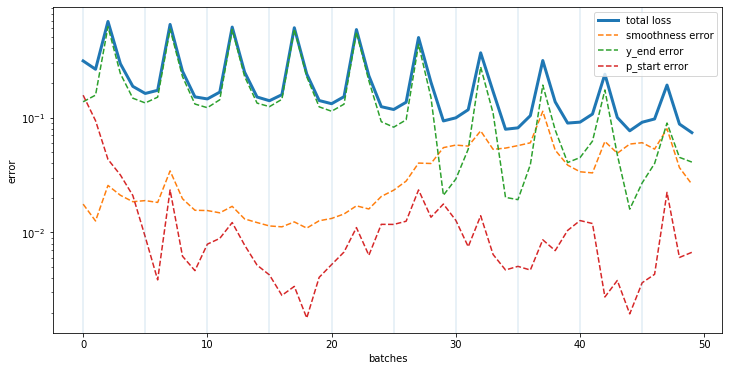

In [4]:
##################################################
#PLOT EVERY LOSS COMPONENT FOR EACH BATCH
timestr = time.strftime("%m%d")
epoch_lines = np.arange(0, epochs*batch, batch)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'total loss', linewidth=3)
smoothness = plt.plot(smoothness_errors, label = 'smoothness error', linestyle='--')
y_end = plt.plot(y_end_errors, label = 'y_end error', linestyle='--')
p_start = plt.plot(p_start_errors, label = 'p_start error', linestyle='--')
plt.legend()
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.savefig('../Plots/Loss_' + timestr + '.png')
plt.show()

In [18]:
#####################################################
#SAVE MODEL
timestr = time.strftime("%m%d")
#Save entire Model
torch.save(model, model_file_path + 'Model_active_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model, model_file_path + 'Model_active_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')

#Save parameters of Model
torch.save(model.state_dict(), model_file_path + 'state_dict/Trained_Model_statedict_active_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_active_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')

#Convert to Torch Script and save for CPP application
input_example = input[4, :]
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
#test_input = torch.tensor([0, 2, 0.5])
#original = model(test_input)
#output_example = traced_script_module(test_input)

traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_active_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')
traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_active_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
print('Model saved')

## Test forward propagation

In [15]:
y_target_test= torch.tensor([0, 2, 0.5])
p = model(y_target_test)
y_pred = Simulate(p)
y_target = y_target_test.detach().numpy()
p = p.detach().numpy()


yTraj_test = dyn.compute(p)

print(yTraj_test.y)
print(np.sum(yTraj_test.y[-3:]-y_target))
print(p)

[ 7.06265214e-05  1.94512096e+00 -2.41065371e-03  3.31315787e-05
  1.92802432e+00 -1.53361098e-03 -2.50241846e-05  1.92932236e+00
  1.56063603e-03 -9.71003644e-05  1.93428661e+00  5.38268862e-03
 -1.62618436e-04  1.93360197e+00  8.86586868e-03 -2.25301555e-04
  1.93395067e+00  1.28316244e-02 -2.85834693e-04  1.93429806e+00
  1.71687823e-02 -3.50448650e-04  1.93525816e+00  2.19732797e-02
 -4.14815980e-04  1.93375367e+00  2.68146188e-02 -4.72172313e-04
  1.93669103e+00  3.27430476e-02 -5.28714245e-04  1.93759710e+00
  3.87745118e-02 -5.78609289e-04  1.93827448e+00  4.51808948e-02
 -6.33160244e-04  1.94006216e+00  5.21617538e-02 -6.88252925e-04
  1.93954718e+00  5.92062964e-02 -7.34688687e-04  1.94146587e+00
  6.70216432e-02 -7.42094754e-04  1.94816654e+00  7.59523267e-02
 -7.49759755e-04  1.95197583e+00  8.48596589e-02 -7.56351785e-04
  1.95427444e+00  9.39290308e-02 -7.62178840e-04  1.95308895e+00
  1.02900194e-01 -7.64573918e-04  1.95149467e+00  1.12150193e-01
 -7.47805104e-04  1.95606